In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import resnet
import numpy as np

from datetime import datetime

import sys 
sys.path.append('..')
from utils_gsp.logger import Logger
from utils_gsp import sps_tools
from gsp_model import GSP_Model
import tools.ipynb_funcs as utilfuncs

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from main import train, validate, accuracy, save_checkpoint, setup_experiment, gsp_sparse_training, AverageMeter

model_names = sorted(name for name in resnet.__dict__
    if name.islower() and not name.startswith("__")
                     and name.startswith("resnet")
                     and callable(resnet.__dict__[name]))

print(model_names)

['resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56']
['resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56']


In [6]:
class Args:
    arch = 'resnet20'
    workers = 4
    epochs=160
    start_epoch=0
    batch_size = 128
    lr = 0.1
    momentum = 0.9
    weight_decay=1e-4
    print_freq = 50
    resume = False
    evaluate = False
    pretrained = False
    half = False
    exp_name = 'gsp_test'

    gpu=None
    logdir = '/logdir'
    gsp_training = True 
    gsp_sps = 0.8
    gsp_int = 150
    gsp_start_ep = -1
    finetune = False
    finetune_sps = 0.9


global args, best_acc1
args = Args
# writer = SummaryWriter()

['resnet110', 'resnet1202', 'resnet20', 'resnet32', 'resnet44', 'resnet56']


In [7]:
# args.resume = './results/gspS80/model_best.pth.tar' # LOAD GSP MODEL

args.resume = './results/gspS0.80/fine_0.9/model_best.pth.tar'
args.finetune = True

In [9]:
# torch.manual_seed(0)
# Setup the experiment
flogger = setup_experiment(args)
args.logger.log_cmd_arguments(args)

model = torch.nn.DataParallel(resnet.__dict__[args.arch]())
model.cuda()

model_gsp = GSP_Model(model)

if args.finetune:
    flogger.info(15*"*" + " Model will be finetuned!! " + 15*"*")
    model_gsp.prune_and_mask_model(sps=args.finetune_sps)
    
# optionally resume from a checkpoint
if args.resume:
    if os.path.isfile(args.resume):
        print("=> loading checkpoint '{}'".format(args.resume))
        checkpoint = torch.load(args.resume)
        args.start_epoch = checkpoint['epoch']
        best_acc1 = checkpoint['best_acc1']
        model_gsp.model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(args.evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
        normalize,
    ]), download=True),
    batch_size=args.batch_size, shuffle=True,
    num_workers=args.workers, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False,
    num_workers=args.workers, pin_memory=True)


# ----------------------- Make a GSP Model -----------------------
print(f"The sparsity of the model is: {model_gsp.get_model_sps():.2f}")
args.writer = SummaryWriter(log_dir=f'results/{args.exp_name}/runs/{datetime.now().strftime("%m-%d_%H:%M")}')

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

# ============================ Setup GSP model ============================
if args.gsp_training:
    gsp_sparse_training(model_gsp, train_loader, args)
    flogger.info(15*"*" + " Model will be trained with GSP Sparsity!! " + 15*"*" )


 input logdir: ./results/gsp_test/logdir 


 RETURNED FILE LOGGER! 

Pruning with threshold : 0.11564972996711731 for layer module.linear.bias
=> loading checkpoint './results/gspS0.80/fine_0.9/model_best.pth.tar'
=> loaded checkpoint 'False' (epoch 230)
Files already downloaded and verified
The sparsity of the model is: 89.97
Current Epoch: 230


In [ ]:

# train(train_loader, model_gsp, criterion, optimizer, 0, args, gsp_mode=False)
# validate(val_loader, model, criterion, args)

In [10]:
model_gsp.get_model_sps()

89.9728282081114

In [ ]:
# model_gsp.force_apply_gsp(0.80)
model_gsp.prune_and_mask_model(sps=0.9)

## MODEL VISUALIZATION

In [13]:
names, weight_l, shape_l, weight_d, layers_d = utilfuncs.get_model_layers(model)

<BarContainer object of 100 artists>

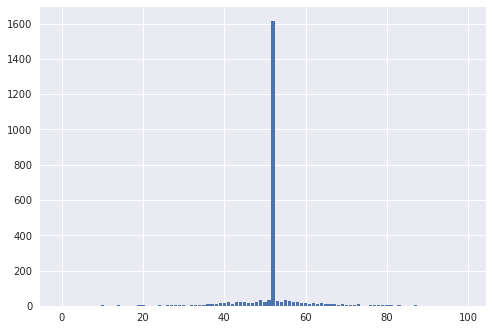

In [14]:
w = weight_d[names[1]]
h_w = torch.histc(w, bins=100).cpu().numpy()
plt.bar( np.arange(len(h_w)), h_w)

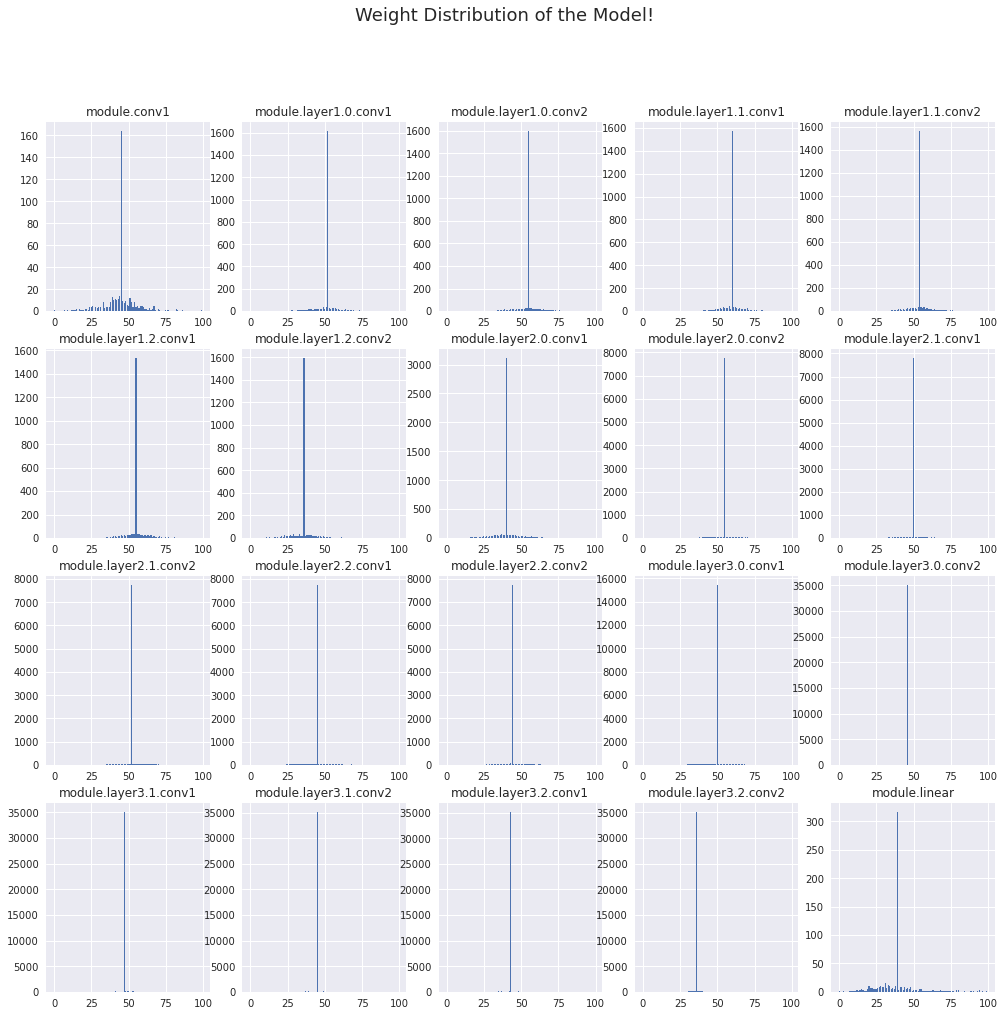

In [15]:
plt.style.use('seaborn')
fig, ax = plt.subplots(nrows=4, ncols=5)

shapes_l = list()
gates_l = list()

weight_cat = torch.tensor([]).cuda()

count = 0
for name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):

        weights = layer.weight.data.detach()
        in_data = torch.histc(weights, bins=100).cpu().numpy()

        # gate_cat = np.concatenate((gate_cat, data))
        # if 'classifier' not in name:
        # weight_cat = np.cat( (weight_cat, in_data) )

        x_vals = np.arange(len(h_w))

        ax.reshape(-1)[count].bar( x_vals, in_data)
        ax.reshape(-1)[count].set_title(name)
        count += 1

fig.set_size_inches(17, 16)
fig.suptitle("Weight Distribution of the Model!", fontsize=18)
plt.savefig('gate_bar.png')